In [222]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats import norm
from scipy.stats import ttest_ind

import constants

In [223]:
def exp_dist(x, x_0, k):
    return np.where(
        x > x_0,
        1 - np.exp(-k * (x - x_0)),
        0
    )

In [224]:
HIST_KWARGS_VEL = {
    'range': (0, 2.5),
    'bins': 25
}

HIST_KWARGS_DIST = {
    'range': (0, 5),
    'bins': 25
}

FIGDIR = 'figs/'

def analyse_export(filename: str, figure_name_prefix: str):
    """
    Analyse a FIESTA kymograph export and generate histograms for the velocity
    and run length distributions.

    :param filename:
        Path to the exported text file
    :param figure_name_prefix:
        Prefix under which the generated histograms are saved.
    """
    print(f'Analysing file {filename}:')
    # Load the file
    dist_arr, time_arr, vel_arr = np.loadtxt(
        fname=filename,
        skiprows=1,
        usecols=(1,2,3),
        unpack=True
    )

    # VELOCITY ANALYISIS:
    print('Velocity:')
    # Calculate mean and std
    mean = np.mean(vel_arr)
    std = np.std(vel_arr)
    print(f'mean {mean}, std {std}, std_err {std/np.sqrt(vel_arr.shape[0])}, median {np.median(vel_arr)}')

    # Generate histogram
    fig_vel, ax_vel, hist, bin_edges = generate_histogramm(vel_arr, **HIST_KWARGS_VEL)
    ax_vel.set_xlabel('Velocity $[\\dfrac{\mu m}{s}]$')
    ax_vel.set_ylabel('Probability density [-]')
    ax_vel.set_title(f'Dataset: {figure_name_prefix}, N = {np.shape(vel_arr)[0]}')
    ax_vel.grid()

    # Fit a normal distribution onto the the histogram
    bin_centers = [np.mean(b_vals) for b_vals in zip(bin_edges[:-1], bin_edges[1:])]
    (fitted_mean, fitted_std), _ = curve_fit(
        f=lambda x, mean, std: norm.pdf(x, loc=mean, scale=std),
        xdata=bin_centers, ydata=hist,
        p0=(mean, std)
    )
    print(f'Fit params: mean {fitted_mean}, std {fitted_std}')

    # Draw the fit in the histogram
    vel_arr_plot = np.linspace(*HIST_KWARGS_VEL['range'], num=150)
    ax_vel.plot(
        vel_arr_plot, norm.pdf(vel_arr_plot, loc=fitted_mean, scale=fitted_std),
        'k-', label='Fitted normal distribution'
    )

    # Add legend
    ax_vel.legend()

    # Save the histogram
    fig_vel.savefig(f'{FIGDIR}/{figure_name_prefix}-velocity.pdf', bbox_inches='tight')

    # RUN LENGTH ANALYSIS:
    print('Run length:')
    # Generate histogram
    fig_dist, ax_dist, hist, bin_edges = generate_histogramm(dist_arr, **HIST_KWARGS_DIST)
    ax_dist.set_xlabel('Run length $[\mu m]$')
    ax_dist.set_ylabel('Probability density [-]')
    ax_dist.set_title(f'Dataset: {figure_name_prefix}, N = {np.shape(dist_arr)[0]}')
    ax_dist.grid()

    # Save the histogram
    fig_dist.savefig(f'{FIGDIR}/{figure_name_prefix}-run_length.pdf', bbox_inches='tight')

    # Compute CDF
    cdf_x_arr, cdf_y_arr = generate_cdf(dist_arr, range=HIST_KWARGS_DIST['range'])

    # Fit an exponential distribution to the CDF
    (fitted_x_0, fitted_k), _ = curve_fit(
        f=exp_dist,
        xdata=cdf_x_arr, ydata=cdf_y_arr
    )
    print(f'Fit params: x_0 {fitted_x_0}, k {fitted_k}')

    # Add CDF figure
    fig_dist_cdf, ax_dist_cdf = plt.subplots(figsize=constants.FIGSIZE)
    ax_dist_cdf.set_xlabel('Run length $[\mu m]$')
    ax_dist_cdf.set_ylabel('Cumulative probability density [-]')
    ax_dist_cdf.set_title(f'Dataset: {figure_name_prefix}, N = {np.shape(dist_arr)[0]}')
    ax_dist_cdf.grid()

    # Plot CDF and exponential distribtion
    ax_dist_cdf.fill_between(cdf_x_arr, np.zeros(cdf_y_arr.shape), cdf_y_arr, label='Measured values')
    ax_dist_cdf.plot(cdf_x_arr, exp_dist(cdf_x_arr, fitted_x_0, fitted_k),
                     'k-', label='Fitted exponential distribution')

    # Add legend and save figure
    ax_dist_cdf.legend()
    fig_dist_cdf.savefig(f'{FIGDIR}/{figure_name_prefix}-run_length-cdf.pdf', bbox_inches='tight')
    print()

def generate_histogramm(arr, **kwargs):
    # Compute histogram
    hist, bin_edges = np.histogram(arr, density=True, **kwargs)
    bin_width = bin_edges[1] - bin_edges[0]

    # Plot histogram
    fig, ax = plt.subplots(figsize=constants.FIGSIZE)
    ax.bar(bin_edges[:-1], hist, width=bin_width, align='edge', label='Histogram')

    return fig, ax, hist, bin_edges

def generate_cdf(arr, range, n=250):
    x_arr = np.linspace(*range, num=n)
    cdf_arr = np.zeros(n)

    for i, x in enumerate(x_arr):
        cdf_arr[i] = sum([
            1 for element in arr
            if element < x
        ])

    cdf_arr /= len(arr)

    return x_arr, cdf_arr


In [225]:
# Error estimation

# Load data
dist_arr, vel_arr = np.loadtxt(
    fname='kymograph_export/error_estimation/24C_ChannelB_63x_Opt1p6_10mW488Laser_100ms_GFP-Kin - Data.txt',
    skiprows=1,
    usecols=(1,3),
    unpack=True
)

dist_err = np.std(dist_arr)
vel_err = np.std(vel_arr)

print(f'Run length [mu m]: mean {np.mean(dist_arr)}, error {dist_err}')
print(f'Velocity [mu m / s]: mean {np.mean(vel_arr)}, error {vel_err}')

Run length [mu m]: mean 2.54942296, error 0.17037722840226746
Velocity [mu m / s]: mean 0.5694704, error 0.04272637686020195


Analysing file kymograph_export/24C-B/24C_ChannelB_63x_Opt1p6_10mW488Laser_100ms_GFP-Kin - Data.txt:
Velocity:
mean 0.7822445899999999, std 0.23887046495971806, std_err 0.016890692559820022, median 0.7698805
Fit params: mean 0.7673701602348195, std 0.17648049526735668
Run length:
Fit params: x_0 0.4926772931444716, k 1.8613311202619498

Analysing file kymograph_export/34C-B/34C_ChannelB_63x_Opt1p6_40mW488Laser_100ms_GFP-Kin - Data.txt:
Velocity:
mean 1.2957212723404257, std 0.2635410303649741, std_err 0.017191521250850227, median 1.253481
Fit params: mean 1.2464825673852464, std 0.18051996168548623
Run length:
Fit params: x_0 0.7593263852135662, k 1.2664313640888465



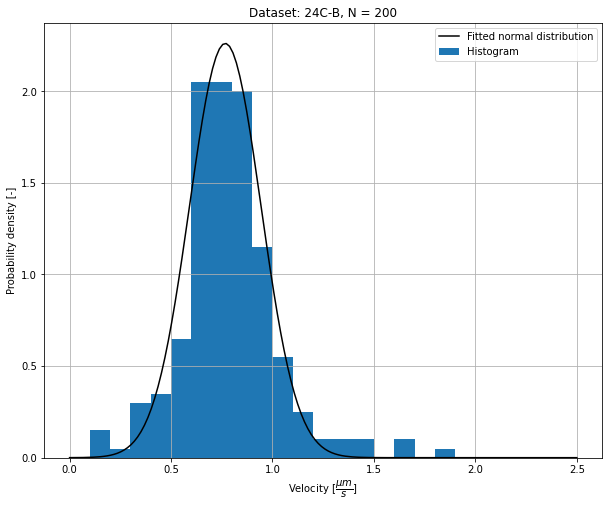

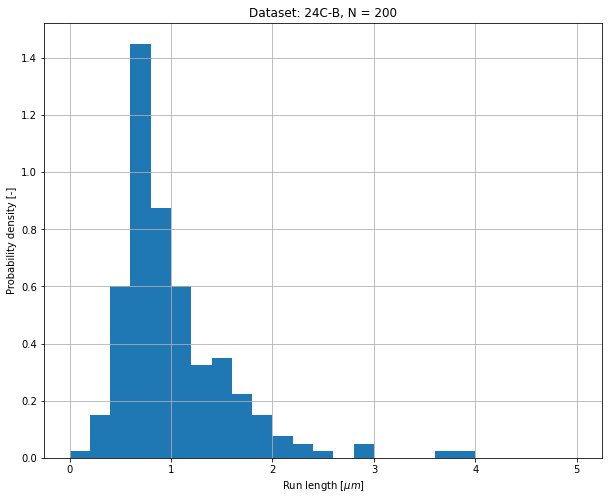

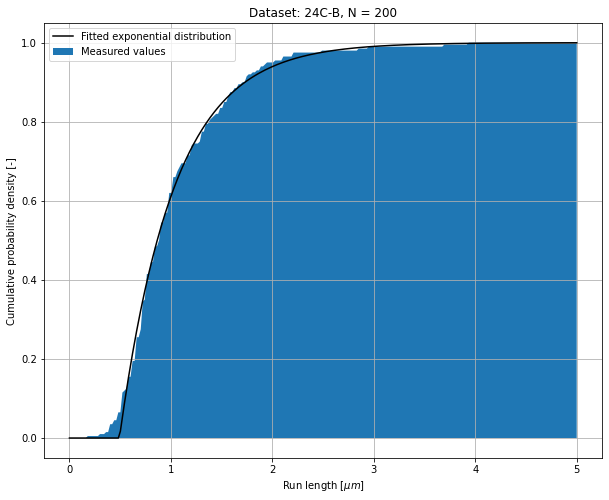

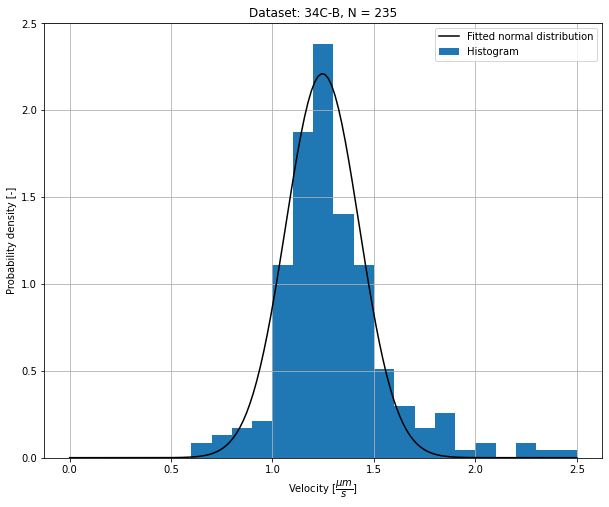

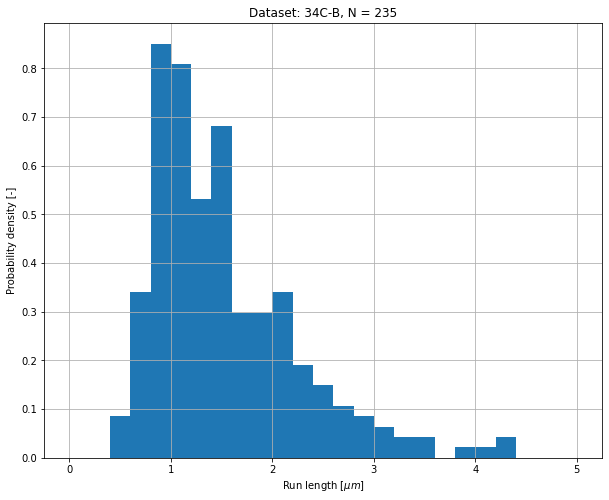

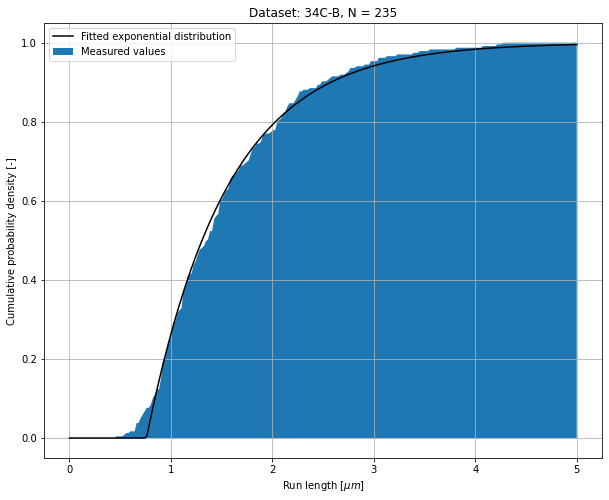

In [226]:
# Velocity and run length evaluation

# List of tuple(filename, output prefix)
EXPORT_FILE_NAMES = [
    ('kymograph_export/24C-B/24C_ChannelB_63x_Opt1p6_10mW488Laser_100ms_GFP-Kin - Data.txt', '24C-B'),
    ('kymograph_export/34C-B/34C_ChannelB_63x_Opt1p6_40mW488Laser_100ms_GFP-Kin - Data.txt', '34C-B')
]

for fname, label in EXPORT_FILE_NAMES:
    analyse_export(fname, label)

In [227]:
# Student's T-Test on the velocity distributions

# Load velocity data
v_arrs = [
    np.loadtxt(
        fname=filename,
        skiprows=1,
        usecols=(3),
        unpack=True
    )
    for filename, _ in EXPORT_FILE_NAMES
]

t_val, p_val = ttest_ind(v_arrs[0], v_arrs[1], equal_var=False)

print(f't-value: {t_val}, p-value: {p_val}')

t-value: -21.256178989664814, p-value: 4.0902631585039144e-69
